In [230]:
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [231]:
# Use the pandas read_csv method to read the file
df = pd.read_csv('data01.csv')
df

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,2,171130,0.0,62,1,25.516870,1,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,2,101659,0.0,78,1,25.822710,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,2,162069,0.0,85,2,23.891779,1,1,0,1,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,2,120967,0.0,79,2,35.288554,0,0,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


## Initial Feature Removal

In [232]:
# define the feature to drop 
feature_drop_list = ['group','ID','diabetes','deficiencyanemias', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'Systolic blood pressure', \
                    'Diastolic blood pressure', 'Urine output']
df_updated = df.drop(feature_drop_list, axis=1)

# Drop the row where outcome = NULL
# df_updated = df_updated.dropna(subset=['outcome'])

# Convert outcome into 1 and 0 values
df_updated['outcome'] = df_updated['outcome'].apply(lambda x: 0 if x < 0.5 else 1)
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Respiratory rate,temperature,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0,72,1,37.588179,0,0,0,68.837838,16.621622,36.714286,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0,75,2,NaN,0,0,0,101.370370,20.851852,36.682540,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0,83,2,26.572634,0,0,0,72.318182,23.640000,36.453704,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0,43,2,83.264629,0,0,0,94.500000,21.857143,36.287037,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0,75,2,31.824842,1,0,0,67.920000,21.360000,36.761905,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,62,1,25.516870,1,1,0,100.125000,24.500000,37.055556,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,0,78,1,25.822710,0,1,0,114.640000,18.958333,35.972222,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,0,85,2,23.891779,1,1,0,52.720000,18.680000,36.777778,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,0,79,2,35.288554,0,0,1,93.400000,22.040000,36.422222,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


## Missing Imputation

In [233]:

def missing_imputation(df):
    """
    Fills missing values in a pandas DataFrame with either median or mean,
    based on the skewness of the columns.
    
    Parameters:
        - df: pandas DataFrame
            Input DataFrame with missing values
        
    Returns:
        - filled_df: pandas DataFrame
            DataFrame with missing values filled using median or mean
    """
    # Calculate skewness of each column
    skewness = df.skew()

    # Create a copy of the input DataFrame to avoid modifying the original DataFrame
    filled_df = df.copy()
    
    output_col = 'outcome'

    # Group the data by the output column
    groups = filled_df.groupby(output_col)

    # Fill missing values with mean/median based on the output column value
    for col in df.columns:
        if col != output_col:  # Skip the output column
            if skewness[col] > 0.5:  # If skewness is greater than 0.5, consider the column as skewed
                filled_df[col] = groups[col].apply(lambda x: x.fillna(x.median()))
            else:
                filled_df[col] = groups[col].apply(lambda x: x.fillna(x.mean()))

    return filled_df

In [234]:
filled_df = missing_imputation(df_updated)
filled_df

C:\Users\Bertram\AppData\Local\Temp\ipykernel_2840\2959445247.py:31: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  filled_df[col] = groups[col].apply(lambda x: x.fillna(x.mean()))
C:\Users\Bertram\AppData\Local\Temp\ipykernel_2840\2959445247.py:31: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  f

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Respiratory rate,temperature,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0,72,1,37.588179,0,0,0,68.837838,16.621622,36.714286,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55
1,0,75,2,28.479451,0,0,0,101.370370,20.851852,36.682540,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55
2,0,83,2,26.572634,0,0,0,72.318182,23.640000,36.453704,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35
3,0,43,2,83.264629,0,0,0,94.500000,21.857143,36.287037,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55
4,0,75,2,31.824842,1,0,0,67.920000,21.360000,36.761905,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,62,1,25.516870,1,1,0,100.125000,24.500000,37.055556,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40
1173,0,78,1,25.822710,0,1,0,114.640000,18.958333,35.972222,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30
1174,0,85,2,23.891779,1,1,0,52.720000,18.680000,36.777778,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55
1175,0,79,2,35.288554,0,0,1,93.400000,22.040000,36.422222,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25


In [235]:
df_updated = filled_df
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Respiratory rate,temperature,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0,72,1,37.588179,0,0,0,68.837838,16.621622,36.714286,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55
1,0,75,2,28.479451,0,0,0,101.370370,20.851852,36.682540,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55
2,0,83,2,26.572634,0,0,0,72.318182,23.640000,36.453704,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35
3,0,43,2,83.264629,0,0,0,94.500000,21.857143,36.287037,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55
4,0,75,2,31.824842,1,0,0,67.920000,21.360000,36.761905,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,62,1,25.516870,1,1,0,100.125000,24.500000,37.055556,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40
1173,0,78,1,25.822710,0,1,0,114.640000,18.958333,35.972222,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30
1174,0,85,2,23.891779,1,1,0,52.720000,18.680000,36.777778,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55
1175,0,79,2,35.288554,0,0,1,93.400000,22.040000,36.422222,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25


## Feature Engineering

### Frank's Part

In [236]:
Good_range = {"M": dict(), "F": dict()}
information = dict()

# Initialize the good range values for male patients
Good_range['M']['age'] = (30, 35)
Good_range['M']['BMI'] = (18.5, 24.9)
Good_range['M']["Systolic blood pressure"] = (90.0, 120.0)
Good_range['M']['Diastolic blood pressure'] = (60, 80)
Good_range['M']["Respiratory rate"] = (12.0, 20.0)
Good_range['M']["temperature"] = (36.5, 37.5)
Good_range['M']["SP O2"] = (95.0, 100.0)
Good_range['M']["Urine output"] = (500.0, 2000.0)
Good_range['M']["Hematocrit"] = (38.8, 50)
Good_range['M']["Heart rate"] = (60.0, 100.0)
Good_range['M']["Diastolic blood pressure"] = (60.0, 80.0)
Good_range['M']["RBC"] = (4.7, 6.1)
Good_range['M']["MCH"] = (27.0, 33.0)
Good_range['M']["MCHC"] = (33, 36.0)
Good_range['M']["MCV"] = (80.0, 100.0)
Good_range['M']["RDW"] = (11.5, 14.5)
Good_range['M']["Leucocyte"] = (4, 11)
Good_range['M']["Platelets"] = (150, 450)
Good_range['M']["Neutrophils"] = (18.0, 75.0)
Good_range['M']["Basophils"] = (0.0, 0.2)
Good_range['M']["Lymphocytes"] = (10.0, 48.0)
Good_range['M']["PT"] = (11.0, 13.5)
Good_range['M']["INR"] = (0.8, 1.2)
Good_range['M']["Creatine kinase"] = (39, 308)
Good_range['M']["Creatinine"] = (0.74, 1.35)
Good_range['M']["Urea nitrogen"] = (6.0, 20.0)
Good_range['M']["Glucose"] = (70, 100)
Good_range['M']["Blood potassium"] = (3.6, 5.2)
Good_range['M']["Blood sodium"] = (135.0, 145.0)
Good_range['M']["Blood calcium"] = (8.6, 10.3)
Good_range['M']["Chloride"] = (96.0, 106.0)
Good_range['M']["Anion gap"] = (3.0, 11.0)
Good_range['M']["Magnesium ion"] = (1.7, 2.2)
Good_range['M']["pH"] = (7.35, 7.45)
Good_range['M']["Bicarbonate"] = (22.0, 29.0)
Good_range['M']["Lactic acid"] = (0.45, 1.98)
Good_range['M']["PCO2"] = (35.0, 45.0)
Good_range['M']["EF"] = (50, 70)

# Initialize the good range values for female patients
Good_range['F']['BMI'] = (18.5, 24.9)
Good_range['F']['age'] = (23, 30)
Good_range['F']["Systolic blood pressure"] = (90.0, 120.0)
Good_range['F']['Diastolic blood pressure'] = (60, 80)
Good_range['F']["Respiratory rate"] = (12.0, 20.0)
Good_range['F']["temperature"] = (36.5, 37.5)
Good_range['F']["SP O2"] = (95.0, 100.0)
Good_range['F']["Urine output"] = (500.0, 2000.0)
Good_range['F']["Hematocrit"] = (34.9, 44.5)
Good_range['F']["Heart rate"] = (60.0, 100.0)
Good_range['F']["Diastolic blood pressure"] = (60.0, 80.0)
Good_range['F']["RBC"] = (4.2, 5.4)
Good_range['F']["MCH"] = (27.0, 33.0)
Good_range['F']["MCHC"] = (33, 36.0)
Good_range['F']["MCV"] = (80.0, 100.0)
Good_range['F']["RDW"] = (11.5, 14.5)
Good_range['F']["Leucocyte"] = (4, 11)
Good_range['F']["Platelets"] = (150, 450)
Good_range['F']["Neutrophils"] = (18.0, 75.0)
Good_range['F']["Basophils"] = (0, 0.2)
Good_range['F']["Lymphocytes"] = (10.0, 48.0)
Good_range['F']["PT"] = (11.0, 13.5)
Good_range['F']["INR"] = (0.8, 1.2)
Good_range['F']["Creatine kinase"] = (26, 192)
Good_range['F']["Creatinine"] = (0.59, 1.04)
Good_range['F']["Urea nitrogen"] = (6.0, 20.0)
Good_range['F']["Glucose"] = (70, 100)
Good_range['F']["Blood potassium"] = (3.6, 5.2)
Good_range['F']["Blood sodium"] = (135.0, 145.0)
Good_range['F']["Blood calcium"] = (8.6, 10.3)
Good_range['F']["Chloride"] = (96.0, 106.0)
Good_range['F']["Anion gap"] = (3.0, 11.0)
Good_range['F']["Magnesium ion"] = (1.7, 2.2)
Good_range['F']["pH"] = (7.35, 7.45)
Good_range['F']["Bicarbonate"] = (22.0, 29.0)
Good_range['F']["Lactic acid"] = (0.45, 1.98)
Good_range['F']["PCO2"] = (35.0, 45.0)
Good_range['F']["EF"] = (50, 70)

#count howmany unserious_diseases the patient has
def unserious_count(df, not_serious_list):
    unserious = []
    for i in range(len(df)):
        row = df.iloc[i]
        counter = 0
        for col in df.columns:
            if col in not_serious_list:
                counter = counter + df.iloc[i][col]
        unserious.append(counter)
    return unserious

# Define a function to transform values based on given parameters
def more_extrem(x, lower,  upper, upper_index, lower_index):
    average = (lower + upper) / 2
    if x >= lower and upper >= x:
        if x < average:
            return average + (average - x) 
        return x
    elif x > upper:
        return upper + upper_index * (x - upper)
    else:
        return (lower - x) * lower_index + upper
    
# Define a function to count the number of features outside the good range
def num_outside_range(patient_data, gender, Good_range):
    num_outside = 0
    for i in range(patient_data.shape[0]):
        feature = df.columns[i]
        if feature == 'gendera' or feature == 'age':
            continue
        val = patient_data[i]
        if gender == 'M':
            lower, upper = Good_range['M'][feature]
        else:
            lower, upper = Good_range['F'][feature]
        if val < lower or val > upper:
            num_outside += 1
    return num_outside

# Define a function to process the age column based on gender
def age_processing(df, upper_index, lower_index):
    for index, row in df.iterrows():
        gender = row['gendera']
        if gender == 1:
            # if gender is M
            df.at[index, 'age'] = more_extrem(row['age'], Good_range['M']['age'][0], Good_range['M']['age'][1], upper_index, lower_index)
        else:
            # if gender is F
            df.at[index, 'age'] = more_extrem(row['age'], Good_range['F']['age'][0], Good_range['F']['age'][1], upper_index, lower_index)

# Define a function to generate a list of health indicators
def count_unhealthy_indicator(df, Good_range):
    howmany = []
    for i in range(len(df)):
        row = df.iloc[i]
        gender = 'M' if row['gendera'] == 1 else 'F'
        num_outside_range = 0
        for col in df.columns:
            if col in Good_range[gender]:
                lower, upper = Good_range[gender][col]
                if row[col] < lower or row[col] > upper:
                    num_outside_range += 1
        howmany.append(num_outside_range)
    return howmany

# Define a function to check if a column has binary values
def is_binary(column):
    return set(column.unique()).issubset({0, 1})

# Define a function to generate a correlation list
def correlatioin_list_generate(df):
    for i in range(len(df)):
        row = df.iloc[i]
        gender = 'M' if row['gendera'] == 1 else 'F'
        num_outside_range = 0
        for col in df.columns:
            if col in Good_range[gender]:
                df.at[i, col] = more_extrem(df.at[i, col], Good_range[gender][col][0], Good_range[gender][col][1], 1.9, 14.9)

    correlation = {col: {'corr': None, 'r2': None} for col in df.columns}
    y = df.iloc[:, 2].to_numpy()
    for col in df.columns:
        X_col = df[[col]]
        print(X_col)
        model = LinearRegression()
        model.fit(X_col, y)
        corr = np.corrcoef(X_col.T, y)[0, 1]
        r2 = model.score(X_col, y)
        correlation[col]['corr'] = corr
        correlation[col]['r2'] = r2
    return correlation

In [237]:
# Process the age column
age_processing(df_updated, 4.1, 7)

In [238]:
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Respiratory rate,temperature,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0,186.7,1,37.588179,0,0,0,68.837838,16.621622,36.714286,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55
1,0,214.5,2,28.479451,0,0,0,101.370370,20.851852,36.682540,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55
2,0,247.3,2,26.572634,0,0,0,72.318182,23.640000,36.453704,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35
3,0,83.3,2,83.264629,0,0,0,94.500000,21.857143,36.287037,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55
4,0,214.5,2,31.824842,1,0,0,67.920000,21.360000,36.761905,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,145.7,1,25.516870,1,1,0,100.125000,24.500000,37.055556,...,136.714286,10.271429,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40
1173,0,211.3,1,25.822710,0,1,0,114.640000,18.958333,35.972222,...,135.680000,10.523529,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30
1174,0,255.5,2,23.891779,1,1,0,52.720000,18.680000,36.777778,...,136.000000,8.466667,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55
1175,0,230.9,2,35.288554,0,0,1,93.400000,22.040000,36.422222,...,140.000000,8.183333,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25


In [239]:
# Extract the target variable and drop unnecessary columns
Y = df_updated[['outcome']].to_numpy()

# Generate the correlation list and information dict
# correlation = correlatioin_list_generate(df_updated)
how_many = count_unhealthy_indicator(df_updated, Good_range)

In [240]:
information = {col: {'corr': None, 'r2': None} for col in df_updated.columns}

# Iterate through DataFrame columns and update information dictionary
for column_name, column_data in df_updated.iteritems():
    if column_name in Good_range['M'].keys():
        information[column_name]["mean"] = (Good_range['M'][column_name][0] + Good_range["M"][column_name][1] + Good_range['F'][column_name][0] + Good_range["F"][column_name][1]) / 4
        information[column_name]["SD"] = df_updated[column_name].std()

df_z = df_updated.copy()

for i in range(len(df_z)):
    for col in df_z.columns:
        if col in Good_range['M'].keys():
            df_z.at[i, col] = (df_z.at[i, col] - information[col]["mean"])/information[col]["SD"]

df_z_weighted_by_correlation = df_z.copy()

df_z['z-score sum'] = df_z.sum(axis=1)

C:\Users\Bertram\AppData\Local\Temp\ipykernel_2840\3172486695.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, column_data in df_updated.iteritems():


In [241]:

for col in df_z_weighted_by_correlation.columns:
    df_z_weighted_by_correlation[col] = df_z_weighted_by_correlation[col] * correlation[col]['corr'] * correlation[col]['r2']

for i in range(len(df)):
    row = df.iloc[i]
    gender = 'M' if row['gendera'] == 1 else 'F'
    num_outside_range = 0
    for col in df.columns:
        if col in Good_range[gender]:
            df.at[i, col] = more_extrem(df.at[i, col], Good_range[gender][col][0], Good_range[gender][col][1], 1.9, 14.9)

In [242]:
df_updated['howmany'] = how_many
df_updated['z-score sum'] = df_z.sum(axis=1)
df_updated['z-score adjusted sum'] = df_z_weighted_by_correlation.sum(axis=1)

In [243]:
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,Respiratory rate,temperature,...,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF,howmany,z-score sum
0,0,186.7,1,37.588179,0,0,0,68.837838,16.621622,36.714286,...,109.166667,13.166667,2.618182,7.230000,21.166667,0.5,40.000000,55,14,4389.675502
1,0,214.5,2,28.479451,0,0,0,101.370370,20.851852,36.682540,...,98.444444,11.444444,1.887500,7.225000,33.444444,0.5,78.000000,55,16,5386.309270
2,0,247.3,2,26.572634,0,0,0,72.318182,23.640000,36.453704,...,105.857143,10.000000,2.157143,7.268000,30.571429,0.5,71.500000,35,18,8761.348763
3,0,83.3,2,83.264629,0,0,0,94.500000,21.857143,36.287037,...,92.071429,12.357143,1.942857,7.370000,38.571429,0.6,75.000000,55,16,1929.996909
4,0,214.5,2,31.824842,1,0,0,67.920000,21.360000,36.761905,...,104.500000,15.166667,1.650000,7.250000,22.000000,0.6,50.000000,55,14,62156.833243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,145.7,1,25.516870,1,1,0,100.125000,24.500000,37.055556,...,94.428571,20.142857,2.714286,7.382962,27.714286,1.6,43.066667,40,16,96560.963637
1173,0,211.3,1,25.822710,0,1,0,114.640000,18.958333,35.972222,...,101.720000,18.160000,2.012500,7.382962,20.480000,1.6,43.066667,30,18,96714.150981
1174,0,255.5,2,23.891779,1,1,0,52.720000,18.680000,36.777778,...,97.285714,14.000000,2.028571,7.382962,28.857143,1.6,43.066667,55,10,102393.549379
1175,0,230.9,2,35.288554,0,0,1,93.400000,22.040000,36.422222,...,104.000000,15.750000,2.090000,7.382962,24.375000,1.6,43.066667,25,17,119994.778027


In [244]:
# Redpiratory rate is in a healthy range between 12-18. 
# The data shows that the normal death rates for 12-22
# Created a binary feature where 12-22 = 0 and everywhere else 
# (too high or too low) its 1.
df_updated['Respiratory rate binned'] = df_updated['Respiratory rate'].apply(lambda x: 0 if 12 <= x <= 22 else 1)
df_updated = df_updated.drop(['Respiratory rate'], axis=1)

# Healthy temperature is in the range of 36 - 37.7
# A binned feature for temp
df_updated['temperature binned'] = df_updated['temperature'].apply(lambda temp: 0 if 36 <= temp <= 37.7 else 1)
df_updated = df_updated.drop(['temperature'], axis=1)

# Healthy SP O2 range is 95% - 100% 
# the data shows low death rates for 94 - 100% 
# There for this range is used for the binned feature
df_updated['SP O2 binned'] = df_updated['SP O2'].apply(lambda sp: 0 if 94 <= sp <= 100 else 1)
df_updated = df_updated.drop(['SP O2'], axis=1)

df_updated['hematocrit binned'] = df_updated.apply(lambda x: 0 if (25 <= x['hematocrit'] <= 40 and x['gendera'] == 2) \
                   or (26 <= x['hematocrit'] <= 43 and x['gendera'] == 1) else 1, axis=1)
df_updated = df_updated.drop(['hematocrit'], axis=1)

# The lowestest death rates are between 3 to 5
# Binned feature in that range
df_updated['RBC_updated'] = df_updated['RBC'].apply(lambda sp: 0 if 3 <= sp <= 5 else 1)
df_updated = df_updated.drop(['RBC'], axis=1)

# Healthy MCH range is 26 - 33
# The lowest death rates are in this range 
df_updated['MCH_updated'] = df_updated['MCH'].apply(lambda mch: 0 if 26 <= mch <= 33 else 1)
df_updated = df_updated.drop(['MCH'], axis=1)

# Healthy MCHC range is above 31
# binned feature in that range
df_updated['MCHC_updated'] = df_updated['MCHC'].apply(lambda mchc: 0 if 31 <= mchc else 1)
df_updated = df_updated.drop(['MCHC'], axis=1)

# Healthy  RDW is between 12 - 15 
# binned feature in that range
df_updated['RDW_updated'] = df_updated['RDW'].apply(lambda rdw: 0 if 12 <= rdw <= 15 else 1)
df_updated = df_updated.drop(['RDW'], axis=1)

# Healthy Lymphocyte is between 22-40
# binned feature in that range
df_updated['Lymphocyte_updated'] = df_updated['Lymphocyte'].apply(lambda lym: 0 if 22 <= lym <= 40 else 1)
df_updated = df_updated.drop(['Lymphocyte'], axis=1)

# Healthy blood sodium is between 135-143
# binned feature in that range
df_updated['Blood_sodium_updated'] = df_updated['Blood sodium'].apply(lambda bs: 0 if 135 <= bs <= 143 else 1)
df_updated = df_updated.drop(['Blood sodium'], axis=1)

# Healthy blood calcium is between 8.6 to 10.3
# binned feature in that range
df_updated['Blood_calcium_updated'] = df_updated['Blood calcium'].apply(lambda bc: 0 if 8.6 <= bc <= 10.3 else 1)
df_updated = df_updated.drop(['Blood calcium'], axis=1)

# Healthy chloride is between 96 to 106
# binned feature in that range
df_updated['Chloride_updated'] = df_updated['Chloride'].apply(lambda chlo: 0 if 96 <= chlo <= 106 else 1)
df_updated = df_updated.drop(['Chloride'], axis=1)

# Healthy Magnesium ion is between 1.7 to 2.2
# binned feature in that range
df_updated['Magnesium_ion_updated'] = df_updated['Magnesium ion'].apply(lambda mag_ion: 0 if 1.7 <= mag_ion <= 2.2 else 1)
df_updated = df_updated.drop(['Magnesium ion'], axis=1)

df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,MCV,Leucocyte,...,hematocrit binned,RBC_updated,MCH_updated,MCHC_updated,RDW_updated,Lymphocyte_updated,Blood_sodium_updated,Blood_calcium_updated,Chloride_updated,Magnesium_ion_updated
0,0,186.7,1,37.588179,0,0,0,68.837838,89.900000,7.650000,...,0,1,0,0,1,1,0,1,1,1
1,0,214.5,2,28.479451,0,0,0,101.370370,98.200000,12.740000,...,0,0,0,0,0,1,0,1,0,0
2,0,247.3,2,26.572634,0,0,0,72.318182,109.800000,5.480000,...,0,1,1,0,1,0,0,1,0,0
3,0,83.3,2,83.264629,0,0,0,94.500000,85.625000,8.225000,...,0,0,0,1,1,1,0,0,1,0
4,0,214.5,2,31.824842,1,0,0,67.920000,91.000000,8.833333,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,145.7,1,25.516870,1,1,0,100.125000,91.142857,7.742857,...,0,0,0,1,1,1,0,0,1,1
1173,0,211.3,1,25.822710,0,1,0,114.640000,89.545455,22.309091,...,0,0,0,0,1,1,0,1,0,0
1174,0,255.5,2,23.891779,1,1,0,52.720000,90.285714,9.228571,...,0,0,0,1,1,0,0,1,0,0
1175,0,230.9,2,35.288554,0,0,1,93.400000,97.375000,6.062500,...,0,0,0,0,1,1,0,1,0,0


## Normalisation

In [245]:

def normalize_continuous_columns(df):
    """
    Normalize continuous columns in a pandas DataFrame using Min-Max scaling.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame with normalized continuous columns.
    """
    # Find continuous columns with more than two unique values
    continuous_cols = []
    for col in df.columns:
        if df[col].nunique() > 2 and df[col].dtype != 'object':
            continuous_cols.append(col)

    # Normalize continuous columns using Min-Max scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    for col in continuous_cols:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

    return df

In [246]:
df_updated = normalize_continuous_columns(df_updated)
df_updated

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,MCV,Leucocyte,...,hematocrit binned,RBC_updated,MCH_updated,MCHC_updated,RDW_updated,Lymphocyte_updated,Blood_sodium_updated,Blood_calcium_updated,Chloride_updated,Magnesium_ion_updated
0,0,0.549125,1,0.264576,0,0,0,0.329339,0.504488,0.116783,...,0,1,0,0,1,1,0,1,1,1
1,0,0.648446,2,0.165161,0,0,0,0.655616,0.657867,0.195514,...,0,0,0,0,0,1,0,1,0,0
2,0,0.765631,2,0.144350,0,0,0,0.364244,0.872228,0.083217,...,0,1,1,0,1,0,0,1,0,0
3,0,0.179707,2,0.763099,0,0,0,0.586711,0.425488,0.125677,...,0,0,0,1,1,1,0,0,1,0
4,0,0.648446,2,0.201673,1,0,0,0.320134,0.524815,0.135086,...,0,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0,0.402644,1,0.132827,1,1,0,0.643126,0.527455,0.118219,...,0,0,0,1,1,1,0,0,1,1
1173,0,0.637013,1,0.136165,0,1,0,0.788700,0.497936,0.343528,...,0,0,0,0,1,1,0,1,0,0
1174,0,0.794927,2,0.115090,1,1,0,0.167689,0.511616,0.141200,...,0,0,0,1,1,0,0,1,0,0
1175,0,0.707038,2,0.239477,0,0,1,0.575679,0.642621,0.092227,...,0,0,0,0,1,1,0,1,0,0


## Sampling 

In [247]:
!pip install imblearn


[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: C:\Users\Bertram\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [248]:

def smote_sampling(X, y, ratio=1.0, random_state=None):

    # Instantiate the RandomOverSampler
    ros = SMOTE(sampling_strategy=ratio, random_state=random_state)

    # Perform oversampling
    X_resampled, y_resampled = ros.fit_resample(X, y)

    # Combine the oversampled feature and target data into a DataFrame
    Xy_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    Xy_resampled['outcome'] = y_resampled

    return Xy_resampled

In [249]:
y = df_updated[['outcome']]
X = df_updated.drop(['outcome'], axis=1)

# Split data into development (70%) and test (30%) sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [250]:
df_sampled = smote_sampling(X_dev, y_dev, ratio=0.18, random_state=18)
df_sampled

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,MCV,Leucocyte,Platelets,...,RBC_updated,MCH_updated,MCHC_updated,RDW_updated,Lymphocyte_updated,Blood_sodium_updated,Blood_calcium_updated,Chloride_updated,Magnesium_ion_updated,outcome
0,0.900679,1,0.064141,1,1,0,0.611784,0.440631,0.112056,0.230905,...,0,0,0,1,1,0,1,1,1,0
1,0.575205,2,0.268286,1,1,0,0.459741,0.623372,0.164475,0.209198,...,0,0,0,1,1,0,0,1,0,1
2,0.138978,1,0.165240,0,0,0,0.624514,0.508646,0.150812,0.229773,...,0,0,0,0,0,0,0,0,1,0
3,0.651661,1,0.165161,1,1,0,0.448345,0.534055,0.362722,0.245726,...,0,0,0,0,1,0,0,0,0,0
4,0.794927,2,0.165161,1,0,0,0.396611,0.534055,0.088683,0.272846,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.607604,1,0.128929,1,0,0,0.467119,0.485300,0.190375,0.274293,...,0,0,0,0,1,1,1,0,0,1
1139,0.330744,1,0.174897,1,0,0,0.462775,0.130650,0.599054,0.349604,...,0,0,0,1,1,1,1,1,0,1
1140,0.572143,1,0.232996,1,1,0,0.829673,0.513168,0.182621,0.173783,...,0,0,0,0,1,0,1,0,0,1
1141,0.668895,2,0.152162,1,0,0,0.714426,0.502905,0.247141,0.190085,...,0,0,0,1,1,0,1,1,0,1


In [251]:
df_updated = df_sampled
df_updated

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,heart rate,MCV,Leucocyte,Platelets,...,RBC_updated,MCH_updated,MCHC_updated,RDW_updated,Lymphocyte_updated,Blood_sodium_updated,Blood_calcium_updated,Chloride_updated,Magnesium_ion_updated,outcome
0,0.900679,1,0.064141,1,1,0,0.611784,0.440631,0.112056,0.230905,...,0,0,0,1,1,0,1,1,1,0
1,0.575205,2,0.268286,1,1,0,0.459741,0.623372,0.164475,0.209198,...,0,0,0,1,1,0,0,1,0,1
2,0.138978,1,0.165240,0,0,0,0.624514,0.508646,0.150812,0.229773,...,0,0,0,0,0,0,0,0,1,0
3,0.651661,1,0.165161,1,1,0,0.448345,0.534055,0.362722,0.245726,...,0,0,0,0,1,0,0,0,0,0
4,0.794927,2,0.165161,1,0,0,0.396611,0.534055,0.088683,0.272846,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.607604,1,0.128929,1,0,0,0.467119,0.485300,0.190375,0.274293,...,0,0,0,0,1,1,1,0,0,1
1139,0.330744,1,0.174897,1,0,0,0.462775,0.130650,0.599054,0.349604,...,0,0,0,1,1,1,1,1,0,1
1140,0.572143,1,0.232996,1,1,0,0.829673,0.513168,0.182621,0.173783,...,0,0,0,0,1,0,1,0,0,1
1141,0.668895,2,0.152162,1,0,0,0.714426,0.502905,0.247141,0.190085,...,0,0,0,1,1,0,1,1,0,1


## Correlation Analysis

In [252]:
def correlation_analysis(df, threshold):
    """
    Calculate the correlation matrix of a dataframe and visualize it using a heatmap.
    Also, return the pairs of features that are correlated above a certain threshold.

    Parameters:
        -- df: pd.DataFrame
            The dataframe for which correlation analysis needs to be performed.
        -- threshold: float
            The correlation threshold above which correlated pairs of features should be returned.

    Returns:
        -- corr_matrix: pd.DataFrame
            The correlation matrix.
        -- correlated_pairs: list of tuples
            The pairs of features that are correlated above the given threshold.
    """
    corr_matrix = df.corr() # Calculate correlation matrix

    # Create a mask to display only the upper triangle of the heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(45, 35))

    # Draw the heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, mask=mask, ax=ax)

    plt.title('Correlation Matrix')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    # Get the correlated pairs of features above the given threshold
    correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    return corr_matrix, correlated_pairs

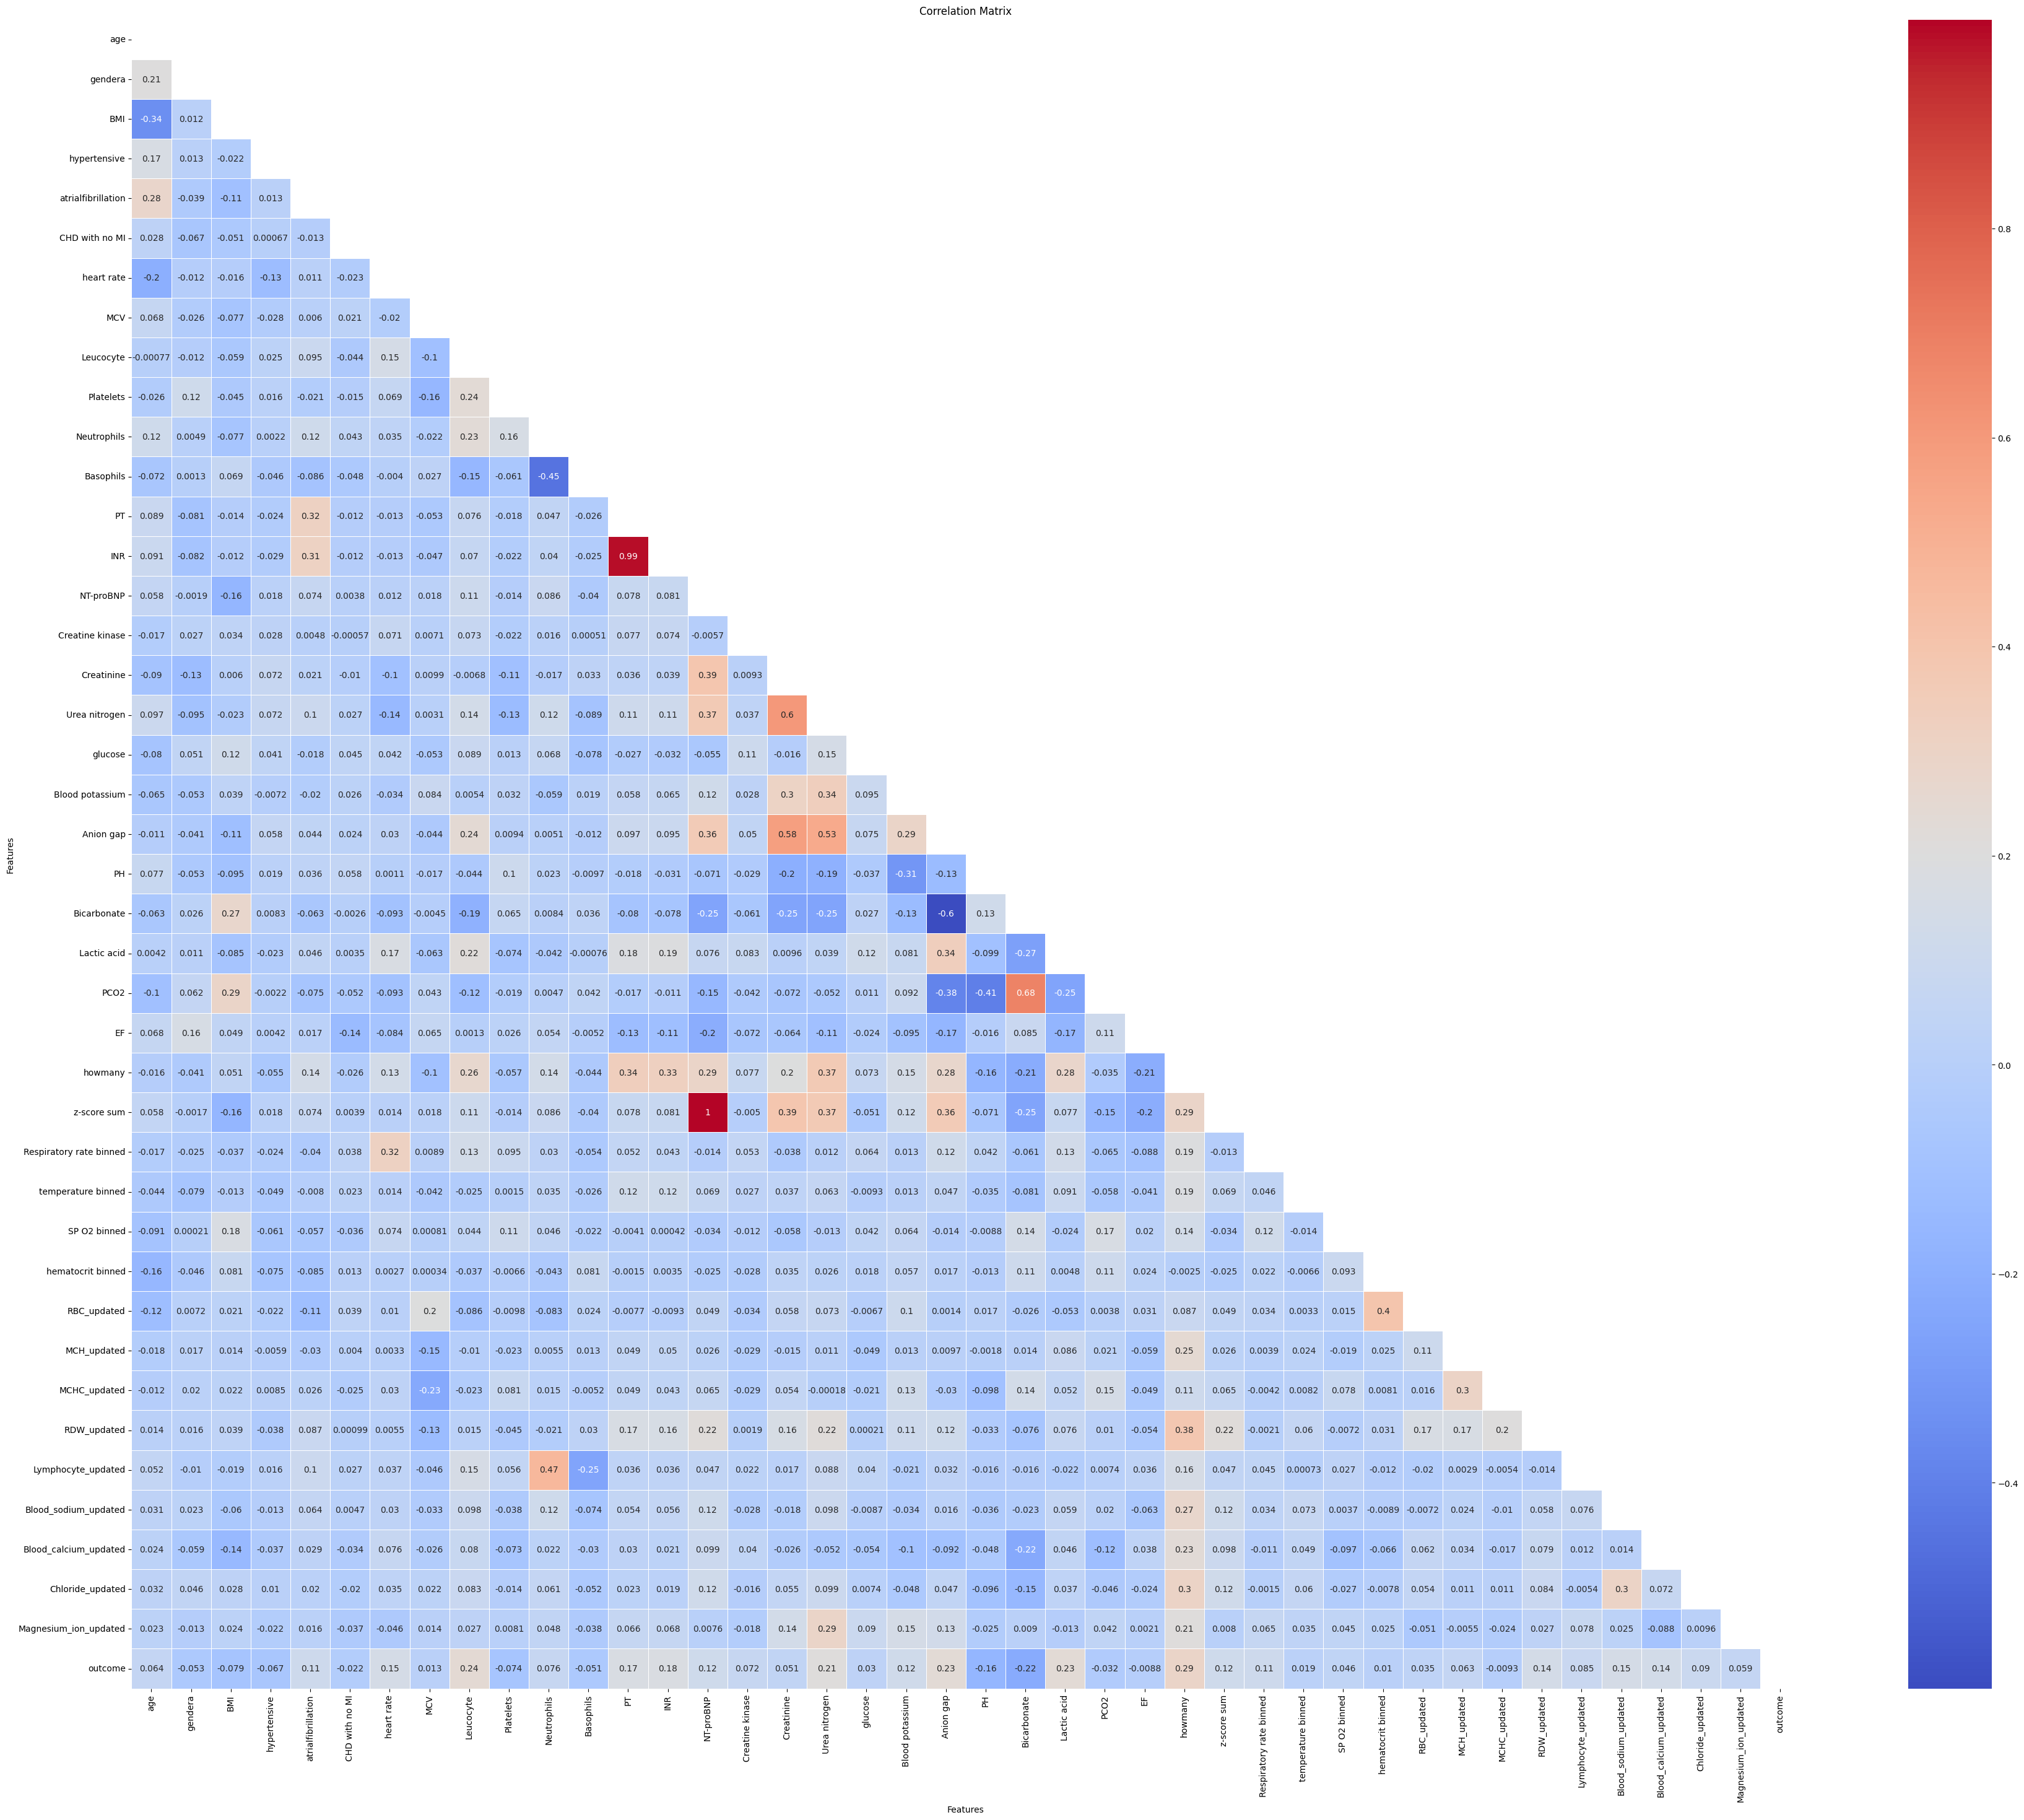

[('PT', 'INR'), ('NT-proBNP', 'z-score sum')]

In [253]:
threshold = 0.9
corr_matrix, correlated_pairs = correlation_analysis(df_updated, threshold)
correlated_pairs

In [254]:

def feature_importance_pvalue(df, target_col, threshold=0.5):
    """
    Perform linear regression and calculate p-values for each feature in a dataframe.

    Parameters:
        -- df: pd.DataFrame
            The dataframe containing the features and target variable.
        -- target_col: str
            The name of the column containing the target variable.

    Returns:
        -- p_values: pd.Series
            A series containing the p-values for each feature.
    """
    # Separate the features and target variable
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Add constant to the features
    X = sm.add_constant(X)

    # Perform linear regression
    model = sm.OLS(y, X).fit()

    # Get the p-values for each feature
    p_values = model.pvalues.drop('const')
    
    # Sort p-values in ascending order
    p_values = p_values.sort_values(ascending=True)

    # Create a list of feature names where p-value is above the threshold
    above_threshold_features = list(p_values[p_values > threshold].index)

    return p_values, above_threshold_features

In [255]:
p_values, above_threshold_features = feature_importance_pvalue(df_updated, 'outcome', threshold=0.7)
p_values

Creatinine                 0.000123
Leucocyte                  0.000175
Blood_calcium_updated      0.001104
Urea nitrogen              0.002061
Anion gap                  0.002084
Lactic acid                0.004434
Blood_sodium_updated       0.004444
PCO2                       0.005876
Platelets                  0.016835
gendera                    0.022152
EF                         0.025311
hypertensive               0.034057
Bicarbonate                0.035255
RDW_updated                0.041574
age                        0.068566
INR                        0.145865
glucose                    0.173412
NT-proBNP                  0.193844
z-score sum                0.193858
MCH_updated                0.203842
Blood potassium            0.209068
BMI                        0.212041
SP O2 binned               0.216921
temperature binned         0.220853
Lymphocyte_updated         0.237051
Creatine kinase            0.291441
RBC_updated                0.293150
PT                         0

In [256]:
above_threshold_features

['Chloride_updated',
 'Basophils',
 'MCV',
 'hematocrit binned',
 'Magnesium_ion_updated']

## Model Build

### XGboost Model

In [257]:
def xgboost_classification(X_dev, y_dev, X_test, y_test):
    """
    Train a binary classification model using XGBoost.

    Parameters
    ----------
    X : array-like or DataFrame, shape (n_samples, n_features)
        The input feature matrix.
    y : array-like, shape (n_samples,)
        The target labels.

    Returns
    -------
    model : XGBClassifier
        The trained XGBoost model.
    accuracy : float
        The accuracy score on the test set.
    """

    # Initialize XGBoost classifier
    model = XGBClassifier(alpha=0.7, max_depth=3, learning_rate=0.9, n_estimators=25, gamma=0.1)

    # Train the model
    model.fit(X_dev, y_dev)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return model, accuracy

In [258]:
y_sampled_data = df_updated[['outcome']]

X_sampled_data = df_updated.drop(['outcome', 'INR', 'NT-proBNP'], axis=1)

X_test_updated = X_test.drop(['INR', 'NT-proBNP'], axis=1)

mod, acc = xgboost_classification(X_sampled_data, y_sampled_data, X_test_updated, y_test)
acc

0.8983050847457628

### Neural Network

In [259]:
def neural_network_classification(X_train, X_test, y_train, y_test):
    """
    Train a binary classification neural network using scikit-learn.

    Parameters:
        - X (array-like or pd.DataFrame): Input features (X)
        - y (array-like or pd.Series): Target labels (y)
        - test_size (float): Test set size (default: 0.3)
        - random_state (int): Random seed for reproducibility (default: None)

    Returns:
        - trained_model (MLPClassifier): Trained neural network model
        - train_acc (float): Training set accuracy
        - test_acc (float): Test set accuracy
    """

    # Create the neural network classifier
    model = MLPClassifier(hidden_layer_sizes=(32,16,16,8,), learning_rate='adaptive', batch_size = 250,\
                      momentum=0.99, alpha=0.009, epsilon=1e-9, max_iter=150, beta_1 = 0.9, \
                          random_state=1234)

    # Train the neural network model
    model.fit(X_train, y_train)

    # Make predictions on the training and test sets
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, test_preds)
    
    # testing
    # X_test has some of it's feature already dropped, 
    # create X_test that still have those features
    X_test_n = df.loc[X_test.index]
    test_metrics("MLP", X_test_n, y_test, test_preds, model.predict_proba(X_test)[:,1])
    
    # Return trained model and accuracy scores
    return model, train_acc, test_acc

C:\Users\Bertram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bertram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


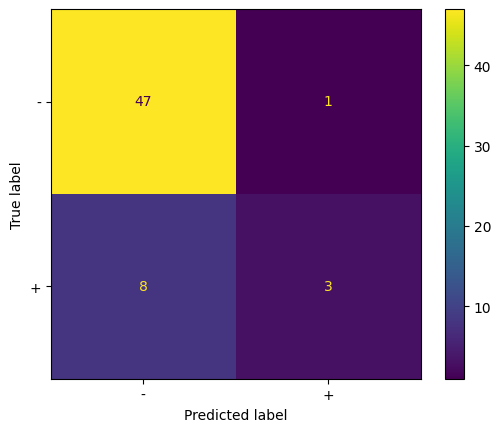

f1-score = 0.39999999999999997


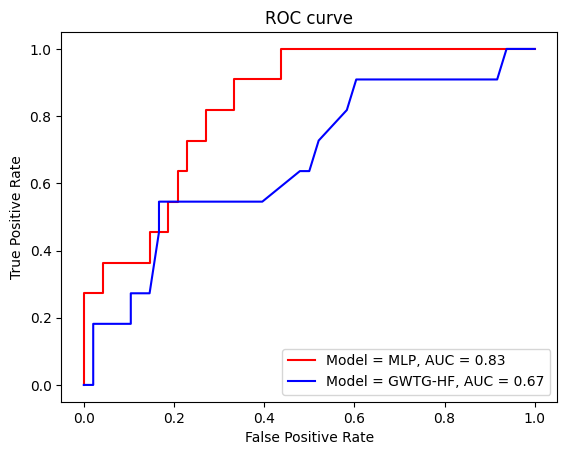

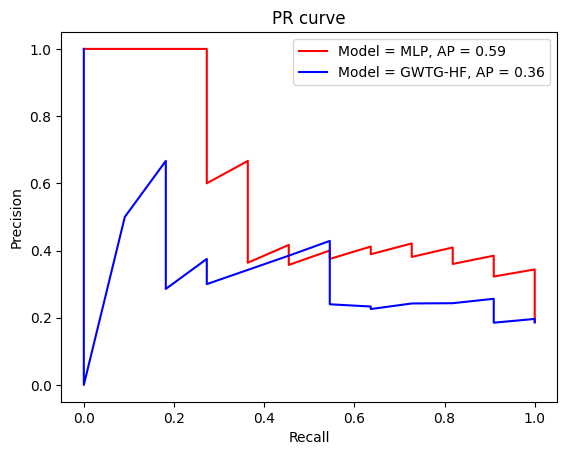

Train Accuracy: 0.937007874015748
Test Accuracy: 0.847457627118644


In [260]:
model, train_acc, test_acc = neural_network_classification(X_sampled_data, X_test_updated, y_sampled_data, y_test)
print("Train Accuracy: " + str(train_acc))
print("Test Accuracy: " + str(test_acc))

In [261]:
def get_COPD_score(f):
    s = []
    for i in f:
        if i == 1:
            s.append(2)
        elif i == 0:
            s.append(0)
        else:
            print("error")
    return np.array(s)

def get_hr_score(f):
    s = []
    for i in f:
        if i <= 79:
            s.append(0)
        elif i >= 80 and i <= 84:
            s.append(1)
        elif i >= 85 and i <= 89:
            s.append(3)
        elif i >= 90 and i <= 94:
            s.append(4)
        elif i >= 95 and i <= 99:
            s.append(5)
        elif i >= 100 and i <= 104:
            s.append(6)
        else:
            s.append(8)
    return np.array(s) 

def get_age_score(f):
    s = []
    for i in f:
        if i <= 19:
            s.append(0)
        elif i >= 20 and i <= 29:
            s.append(3)
        elif i >= 30 and i <= 39:
            s.append(6)
        elif i >= 40 and i <= 49:
            s.append(8)
        elif i >= 50 and i <= 59:
            s.append(11)
        elif i >= 60 and i <= 69:
            s.append(14)
        elif i >= 70 and i <= 79:
            s.append(17)
        elif i >= 80 and i <= 89:
            s.append(19)
        elif i >= 90 and i <= 99:
            s.append(22)
        elif i >= 100 and i <= 109:
            s.append(25)
        else:
            s.append(28)
    return np.array(s)

def get_sodium_score(f):
    s = []
    for i in f:
        if i <= 130:
            s.append(4)
        elif i >= 131 and i <= 133:
            s.append(3)
        elif i >= 134 and i <= 136:
            s.append(2)
        elif i >= 137 and i <= 138:
            s.append(1)
        else:
            s.append(0)
    return np.array(s)

def get_BUN_score(f):
    s = []
    for i in f:
        if i <= 9:
            s.append(0)
        elif i >= 10 and i <= 19:
            s.append(2)
        elif i >= 20 and i <= 29:
            s.append(4)
        elif i >= 30 and i <= 39:
            s.append(6)
        elif i >= 40 and i <= 49:
            s.append(8)
        elif i >= 50 and i <= 59:
            s.append(9)
        elif i >= 60 and i <= 69:
            s.append(11)
        elif i >= 70 and i <= 79:
            s.append(13)
        elif i >= 80 and i <= 89:
            s.append(15)
        elif i >= 90 and i <= 99:
            s.append(17)
        elif i >= 100 and i <= 109:
            s.append(19)
        elif i >= 110 and i <= 119:
            s.append(21)
        elif i >= 120 and i <= 129:
            s.append(23)
        elif i >= 130 and i <= 139:
            s.append(25)
        elif i >= 140 and i <= 149:
            s.append(27)
        else:
            s.append(28)
    return np.array(s)

def get_systolic_score(f):
    s = []
    for i in f:
        if i <= 59:
            s.append(28)
        elif i >= 60 and i <= 69:
            s.append(26)
        elif i >= 70 and i <= 79:
            s.append(24)
        elif i >= 80 and i <= 89:
            s.append(23)
        elif i >= 90 and i <= 99:
            s.append(21)
        elif i >= 100 and i <= 109:
            s.append(19)
        elif i >= 110 and i <= 119:
            s.append(17)
        elif i >= 120 and i <= 129:
            s.append(15)
        elif i >= 130 and i <= 139:
            s.append(13)
        elif i >= 140 and i <= 149:
            s.append(11)
        elif i >= 150 and i <= 159:
            s.append(9)
        elif i >= 160 and i <= 169:
            s.append(8)
        elif i >= 170 and i <= 179:
            s.append(6)
        elif i >= 180 and i <= 189:
            s.append(4)
        elif i >= 190 and i <= 199:
            s.append(3)
        else:
            s.append(0)
    return np.array(s)

def get_GWTG_HF_score(X):
    sum = np.zeros(X.shape[0])
    # Systolic BP
    sum += get_systolic_score(X["Systolic blood pressure"].to_numpy())
    # BUN
    sum += get_BUN_score(X["Urea nitrogen"].to_numpy())
    # Sodium
    sum += get_sodium_score(X["Blood sodium"].to_numpy())
    # Age
    sum += get_age_score(X["age"].to_numpy())
    # Heart Rate
    sum += get_hr_score(X["heart rate"].to_numpy())
    # Ethnicity (Missing)
    
    # COPD
    sum += get_COPD_score(X["COPD"].to_numpy())
    return sum

In [262]:
# TODO:
# change train test split

# X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Model metrics
def test_metrics(name, X, y_t, y_p, y_s = []):
    # Confusion Matrix
    cm = confusion_matrix(y_t, y_p, labels = [0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["-", "+"])
    disp.plot()
    plt.show()
    # F1-score
    print(f"f1-score = {f1_score(y_t, y_p):.2f}")
    
    
    if (len(y_s) != 0):
        # get GWTG-HF risk score
        plt.figure()
        gwtg_s = get_GWTG_HF_score(X)
        # ROC curve
        # NOTE ROC curve is not a good metric for inbalance class
        # AUC-ROC curve for our model
        fpr, tpr, thresholds = roc_curve(y_t, y_s, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color = "red", label = f"Model = {name}, AUC = {roc_auc:.2f}")
        # AUC-ROC curve for GWTG_HF
        
        fpr, tpr, thresholds = roc_curve(y_t, gwtg_s, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color = "blue", label = f"Model = GWTG-HF, AUC = {roc_auc:.2f}")
        plt.legend()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.show()
        
        plt.figure()
        # PR curve
        # AUC-PR curve for our model
        precision, recall, _ = precision_recall_curve(y_t, y_s)
        ap = average_precision_score(y_t, y_s)
        plt.plot(recall, precision, color = "red", label = f"Model = {name}, AP = {ap:.2f}")
        
        # AUC-PR curve for GWTF_HF
        precision, recall, _ = precision_recall_curve(y_t, gwtg_s)
        ap = average_precision_score(y_t, gwtg_s)
        plt.plot(recall, precision, color = "blue", label = f"Model = GWTG-HF, AP = {ap:.2f}")
        plt.legend()
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("PR curve")
        plt.show()
    
    
    